In [1]:
import pandas as pd 
df = pd.read_csv("C:\Mukesh\Backup_Project_file\cab_driving_industry_optimized.csv")

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\dipak\AppData\Local\Temp\ipykernel_6804\238064784.py:2: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("C:\Mukesh\Backup_Project_file\cab_driving_industry_optimized.csv")


In [10]:
from sqlalchemy import create_engine

In [11]:

def get_postgres_connection():
    user = "postgres"
    password = "system"
    host = "localhost"
    port = "5432"
    database = df

    engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")
    return engine

In [12]:
def upload_to_postgres(df, table_name):
    engine = get_postgres_connection()
    df.to_sql(table_name, engine, index=False, if_exists='replace')
    print(f"Table '{table_name}' uploaded to PostgreSQL successfully!")

In [13]:

def run_pg_query(query):
    engine = get_postgres_connection()
    return pd.read_sql(query, engine)

In [14]:
df_gender = run_pg_query("SELECT Gender, COUNT(*) FROM bank_data GROUP BY Gender")
print(df_gender)

OperationalError: (pymysql.err.OperationalError) (2013, 'Lost connection to MySQL server during query ([WinError 10054] An existing connection was forcibly closed by the remote host)')
(Background on this error at: https://sqlalche.me/e/20/e3q8)

# ----------------------------------------------------------------------

In [4]:
import sys
import os
import re
import argparse
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from docx import Document
from docx.shared import Inches

In [5]:
warnings.filterwarnings('ignore')

# ----------------------------- CONFIG ---------------------------------
CATEGORICAL_CARDINALITY_THRESHOLD = 30  # if unique values <= this -> categorical (unless dtype already numeric)
SAMPLE_FOR_SCATTER = 5000  # when plotting pairwise numeric scatter, sample if dataset is large
PLOTS_DIR = "eda_plots"
REPORT_NAME_TEMPLATE = "EDA_Report_{basename}.docx"

def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)


def is_date_series(s, n=5):
    # try to parse a few values as dates
    sample = s.dropna().astype(str).head(n)
    if sample.empty:
        return False
    success = 0
    for v in sample:
        try:
            pd.to_datetime(v)
            success += 1
        except Exception:
            pass
    return success >= max(1, int(0.6 * len(sample)))

In [6]:
# ----------------------------- CLEANING --------------------------------

def clean_strings(series: pd.Series) -> pd.Series:
    # strip whitespace, normalize internal spaces, collapse multiple spaces, remove non-printables
    def _clean(val):
        if not isinstance(val, str):
            return val
        v = val.strip()
        v = re.sub(r"\s+", " ", v)
        v = re.sub(r"[\x00-\x1f\x7f]+", "", v)
        return v
    return series.map(_clean)


def coerce_numeric(series: pd.Series) -> pd.Series:
    # remove common currency and thousand separators then coerce
    def _norm(v):
        if pd.isna(v):
            return v
        if isinstance(v, (int, float, np.number)):
            return v
        s = str(v)
        s = s.strip()
        # remove common currency symbols and percentages
        s = re.sub(r"[$€£₹,%]", "", s)
        # remove thousands separators like 1,234 or 1 234
        s = s.replace(',', '').replace(' ', '')
        # handle parentheses - negative numbers like (123)
        if re.match(r'^\(.*\)$', s):
            s = '-' + s[1:-1]
        return s
    normed = series.map(_norm)
    coerced = pd.to_numeric(normed, errors='coerce')
    return coerced


def coerce_datetime(series: pd.Series) -> pd.Series:
    try:
        return pd.to_datetime(series, errors='coerce', infer_datetime_format=True)
    except Exception:
        return series


def smart_clean(df: pd.DataFrame) -> (pd.DataFrame, dict):
    """
    Attempt to clean common messy patterns and produce a report dict of actions.
    """
    report = { 'initial_shape': df.shape, 'columns': {} }

    # Drop fully empty columns
    empty_cols = [c for c in df.columns if df[c].isna().all()]
    if empty_cols:
        df = df.drop(columns=empty_cols)
        report['dropped_empty_columns'] = empty_cols

    # Trim column names
    df.columns = [str(c).strip() for c in df.columns]

    # Convert object columns: strip strings
    for col in df.columns:
        col_report = {}
        s = df[col]
        if s.dtype == object:
            before_nonnull = s.dropna().shape[0]
            df[col] = clean_strings(s)
            df[col] = df[col].astype(str).str.upper()
            col_report['cleaned_strings'] = True
        else:
            col_report['cleaned_strings'] = False

        # attempt to coerce datetime
        if is_date_series(df[col]):
            df[col] = coerce_datetime(df[col])
            col_report['coerced_to_datetime'] = True
        else:
            col_report['coerced_to_datetime'] = False

        # attempt to coerce numeric if many values look numeric
        coerced_num = coerce_numeric(df[col])
        num_nonnull = coerced_num.dropna().shape[0]
        total_nonnull = df[col].dropna().shape[0]
        if total_nonnull > 0 and num_nonnull >= 0.6 * total_nonnull:
            df[col] = coerced_num
            col_report['coerced_to_numeric'] = True
        else:
            col_report['coerced_to_numeric'] = False

        report['columns'][col] = col_report

    # Drop duplicate rows
    before = df.shape[0]
    df = df.drop_duplicates()
    after = df.shape[0]
    report['duplicates_dropped'] = before - after
   
    # Reset index
    df = df.reset_index(drop=True)

    report['final_shape'] = df.shape
    return df, report


def clean_dataset(df):
    df = df.copy()

    # Strip whitespace
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip()

    # Convert numeric-looking strings to numbers
    for col in df.columns:
        df[col] = df[col].replace(
            {',': '', '₹': '', '$': '', '%': ''},
            regex=True
        )

        # Try converting everything to numbers
        df[col] = pd.to_numeric(df[col], errors='ignore')

    # Missing value handling
    for col in df.select_dtypes(include=['number']).columns:
        df[col] = df[col].fillna(df[col].median())

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna(df[col].mode()[0])

    return df



In [7]:
# ------------------------ TYPE DETECTION --------------------------------

def detect_column_types(df: pd.DataFrame) -> dict:
    types = { 'numeric': [], 'categorical': [], 'datetime': [], 'other': [] }
    for col in df.columns:
        s = df[col]
        if pd.api.types.is_datetime64_any_dtype(s):
            types['datetime'].append(col)
            continue
        if pd.api.types.is_numeric_dtype(s):
            unique = s.dropna().unique()
            if len(unique) <= CATEGORICAL_CARDINALITY_THRESHOLD:
                types['categorical'].append(col)
            else:
                types['numeric'].append(col)
            continue
        # object-like: decide
        nunique = s.dropna().nunique()
        if is_date_series(s) and nunique > 0:
            types['datetime'].append(col)
        elif nunique <= CATEGORICAL_CARDINALITY_THRESHOLD:
            types['categorical'].append(col)
        else:
            # try numeric coercion check
            coerced = pd.to_numeric(s.astype(str).map(lambda x: re.sub(r"[$,€£₹% ]", "", str(x)) if pd.notna(x) else x), errors='coerce')
            num_nonnull = coerced.dropna().shape[0]
            if num_nonnull >= 0.6 * s.dropna().shape[0]:
                types['numeric'].append(col)
            else:
                types['other'].append(col)
    return types

In [8]:
# ------------------------ MISSING VALUE HANDLING ------------------------

def handle_missing(df: pd.DataFrame, types: dict, strategy_numeric='median', strategy_categorical='mode') -> (pd.DataFrame, dict):
    report = {}
    for col in df.columns:
        missing = df[col].isna().sum()
        pct = 100.0 * missing / max(1, df.shape[0])
        report[col] = {'missing_count': int(missing), 'missing_pct': round(pct,2)}
        if missing == 0:
            continue
        if col in types['numeric']:
            if strategy_numeric == 'median':
                fill = df[col].median()
            elif strategy_numeric == 'mean':
                fill = df[col].mean()
            else:
                fill = 0
            df[col] = df[col].fillna(fill)
            report[col]['imputed_with'] = 'numeric_'+strategy_numeric
            report[col]['imputed_value'] = float(fill) if pd.notna(fill) else None
        elif col in types['categorical']:
            if strategy_categorical == 'mode':
                try:
                    fill = df[col].mode(dropna=True).iloc[0]
                except Exception:
                    fill = 'Unknown'
            else:
                fill = 'Unknown'
            df[col] = df[col].fillna(fill)
            report[col]['imputed_with'] = 'categorical_'+strategy_categorical
            report[col]['imputed_value'] = str(fill)
        else:
            # default: fill forward then backward then a placeholder
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill').fillna('Missing')
            report[col]['imputed_with'] = 'ffill_bfill_or_placeholder'
    return df, report

In [9]:
# ------------------------ PLOTTING HELPERS ------------------------------

def save_histogram(series, colname, outdir):
    plt.figure(figsize=(6,4))
    if pd.api.types.is_numeric_dtype(series):
        series.dropna().plot.hist(bins=30)
        plt.xlabel(colname)
        plt.title(f'Histogram of {colname}')
    else:
        vc = series.dropna().value_counts().head(20)
        vc.plot.bar()
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Top categories: {colname}')
    path = os.path.join(outdir, f"hist_{colname}.png")
    plt.tight_layout()
    plt.savefig(path)
    plt.close()
    return path


def save_boxplot(series, colname, outdir):
    if not pd.api.types.is_numeric_dtype(series):
        return None
    plt.figure(figsize=(6,3))
    sns.boxplot(x=series.dropna())
    plt.title(f'Boxplot of {colname}')
    path = os.path.join(outdir, f"box_{colname}.png")
    plt.tight_layout()
    plt.savefig(path)
    plt.close()
    return path


def save_scatter(x, y, xname, yname, outdir, sample=SAMPLE_FOR_SCATTER):
    # sample to keep plots readable
    df = pd.concat([x, y], axis=1).dropna()
    if df.shape[0] > sample:
        df = df.sample(sample, random_state=1)
    plt.figure(figsize=(6,4))
    plt.scatter(df.iloc[:,0], df.iloc[:,1], alpha=0.5, s=10)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title(f'{yname} vs {xname}')
    path = os.path.join(outdir, f"scatter_{xname}__{yname}.png")
    plt.tight_layout()
    plt.savefig(path)
    plt.close()
    return path


In [10]:
# ------------------------ REPORT GENERATION -----------------------------

def create_word_report(basename, df, types, clean_report, missing_report, univariate, bivariate, plots_dir, out_path=None):
    doc = Document()
    doc.add_heading(f'Automated EDA Report: {basename}', level=1)
    doc.add_paragraph(f'Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

    # Summary
    doc.add_heading('1. Dataset Summary', level=2)
    doc.add_paragraph(f"Original shape: {clean_report.get('initial_shape')}")
    doc.add_paragraph(f"After cleaning shape: {clean_report.get('final_shape')}")
    if clean_report.get('dropped_empty_columns'):
        doc.add_paragraph('Dropped empty columns: ' + ', '.join(clean_report.get('dropped_empty_columns')))
    doc.add_paragraph(f"Duplicates dropped: {clean_report.get('duplicates_dropped')}")

    # Column types
    doc.add_heading('2. Detected Column Types', level=2)
    for t in ['numeric','categorical','datetime','other']:
        doc.add_paragraph(f"{t.title()} ({len(types[t])}): {', '.join(types[t]) if types[t] else 'None'}")

    # Missingness
    doc.add_heading('3. Missing Values & Imputation', level=2)
    table = doc.add_table(rows=1, cols=4)
    hdr = table.rows[0].cells
    hdr[0].text = 'Column'
    hdr[1].text = 'Missing Count'
    hdr[2].text = 'Missing %'
    hdr[3].text = 'Imputed With'
    for col, info in missing_report.items():
        row = table.add_row().cells
        row[0].text = col
        row[1].text = str(info.get('missing_count', ''))
        row[2].text = str(info.get('missing_pct', ''))
        row[3].text = str(info.get('imputed_with', ''))

    # Univariate highlights
    doc.add_heading('4. Univariate Analysis (highlights)', level=2)
    for col, stats in univariate.items():
        doc.add_heading(col, level=3)
        doc.add_paragraph(stats.get('summary', ''))
        if stats.get('hist'):
            doc.add_paragraph('Histogram:')
            doc.add_picture(stats['hist'], width=Inches(6))
        if stats.get('box'):
            doc.add_paragraph('Boxplot:')
            doc.add_picture(stats['box'], width=Inches(6))

    # Bivariate highlights
    doc.add_heading('5. Bivariate Analysis (highlights)', level=2)
    for name, info in bivariate.items():
        doc.add_heading(name, level=3)
        doc.add_paragraph(info.get('text', ''))
        if info.get('plot'):
            doc.add_paragraph('Plot:')
            doc.add_picture(info['plot'], width=Inches(6))

    # Save
    if not out_path:
        out_path = REPORT_NAME_TEMPLATE.format(basename=basename)
    doc.save(out_path)
    return out_path

In [11]:

# ------------------------ ANALYSIS LOGIC -------------------------------

def run_analysis(df: pd.DataFrame, basename: str, outdir: str) -> str:
    ensure_dir(outdir)

    clean_df, clean_report = smart_clean(df.copy())

    types = detect_column_types(clean_df)

    # Missing handling
    handled_df, missing_report = handle_missing(clean_df.copy(), types)

    # Univariate: create summary and plots for top columns (all columns by default)
    univariate = {}
    for col in handled_df.columns:
        stats = {}
        s = handled_df[col]
        if col in types['numeric']:
            desc = s.describe().to_dict()
            stats['summary'] = f"Numeric column — count={int(desc.get('count',0))}, mean={desc.get('mean'):.3f}, std={desc.get('std'):.3f}, min={desc.get('min')}, 25%={desc.get('25%')}, 50%={desc.get('50%')}, 75%={desc.get('75%')}, max={desc.get('max')}"
        else:
            vc = s.value_counts(dropna=True).head(10)
            stats['summary'] = 'Top categories:\n' + '\n'.join([f"{i}: {v}" for i,v in vc.items()])
        hist = save_histogram(s, col, outdir)
        stats['hist'] = hist
        box = save_boxplot(s, col, outdir)
        stats['box'] = box
        univariate[col] = stats

    # Bivariate: correlations for numeric; top numeric pairs and some categorical cross-tabs
    bivariate = {}
    # Numeric correlation
    if len(types['numeric']) >= 2:
        num_df = handled_df[types['numeric']]
        corr = num_df.corr()
        # save correlation heatmap
        plt.figure(figsize=(max(6, len(types['numeric'])), max(6, len(types['numeric']))))
        sns.heatmap(corr, annot=True, fmt='.2f', square=True, cbar_kws={'shrink':0.5})
        corr_path = os.path.join(outdir, 'correlation_matrix.png')
        plt.tight_layout()
        plt.savefig(corr_path)
        plt.close()
        bivariate['Numeric Correlation Matrix'] = {'text': 'Pearson correlation matrix for numeric columns', 'plot': corr_path}
        # save a few top correlated scatterplots
        flat = corr.abs().unstack().reset_index()
        flat.columns = ['x','y','corr']
        flat = flat[flat['x'] != flat['y']]
        flat = flat.sort_values('corr', ascending=False).drop_duplicates(subset=['corr'])
        pairs = flat.head(6)
        for _, row in pairs.iterrows():
            x = row['x']; y = row['y']
            path = save_scatter(handled_df[x], handled_df[y], x, y, outdir)
            bivariate[f'{y} vs {x}'] = {'text': f'Scatter: correlation {corr.loc[x,y]:.3f}', 'plot': path}

    # Numeric by categorical
    for cat in types['categorical'][:6]:  # limit for report size
        for num in types['numeric'][:6]:
            grp = handled_df.groupby(cat)[num].agg(['count','mean','median','std']).sort_values('count', ascending=False).head(10)
            txt = f"Group stats for numeric column '{num}' by category '{cat}':\n" + grp.reset_index().to_string(index=False)
            # boxplot: numeric split by category (top 6 categories)
            topcats = handled_df[cat].value_counts().head(6).index.tolist()
            plt.figure(figsize=(8,4))
            sns.boxplot(x=handled_df[cat].where(handled_df[cat].isin(topcats)), y=handled_df[num])
            plt.xticks(rotation=45)
            path = os.path.join(outdir, f'box_{num}_by_{cat}.png')
            plt.tight_layout()
            plt.savefig(path)
            plt.close()
            bivariate[f'{num} by {cat}'] = {'text': txt, 'plot': path}

    # Categorical vs Categorical: crosstabs for top pairs
    cats = types['categorical']
    if len(cats) >= 2:
        for i in range(min(4, len(cats))):
            for j in range(i+1, min(4, len(cats))):
                a = cats[i]; b = cats[j]
                ct = pd.crosstab(handled_df[a], handled_df[b])
                text = f'Crosstab {a} x {b} (top rows):\n' + ct.head(10).to_string()
                # visualize stacked bar of top categories
                top_a = handled_df[a].value_counts().head(6).index
                subset = handled_df[handled_df[a].isin(top_a)]
                plotdf = pd.crosstab(subset[a], subset[b])
                plotdf.plot(kind='bar', stacked=True, figsize=(8,4))
                plt.xticks(rotation=45)
                path = os.path.join(outdir, f'ct_{a}__{b}.png')
                plt.tight_layout()
                plt.savefig(path)
                plt.close()
                bivariate[f'crosstab_{a}_vs_{b}'] = {'text': text, 'plot': path}

    # Create report docx
    report_path = create_word_report(basename, handled_df, types, clean_report, missing_report, univariate, bivariate, outdir)
    return report_path

Loaded dataset: (100000, 25)


TypeError: no numeric data to plot

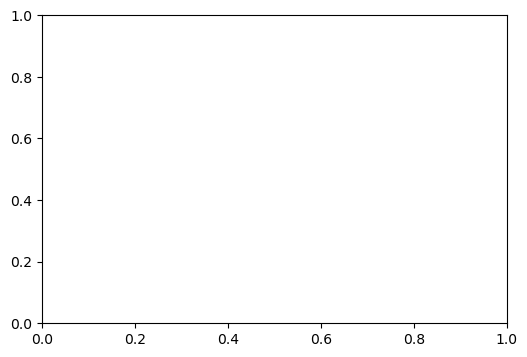

In [12]:
# ------------------------ CLI ------------------------------------------

def load_dataset(path):
    ext = os.path.splitext(path)[1].lower()
    if ext in ['.csv', '.txt']:
        return pd.read_csv(path, low_memory=False)
    elif ext in ['.xls', '.xlsx']:
        return pd.read_excel(path, sheet_name=0)
    else:
        # attempt CSV first
        try:
            return pd.read_csv(path, low_memory=False)
        except Exception:
            raise ValueError('Unsupported file type. Please provide CSV or Excel file.')



if __name__ == "__main__":
    path = "C:\Mukesh\Backup_Project_file\cab_driving_industry_dataset_final (1).csv"   # <-- Put your file name here  
    df = load_dataset(path)
    
    basename = os.path.splitext(os.path.basename(path))[0]
    outdir = PLOTS_DIR
    ensure_dir(outdir)

    print("Loaded dataset:", df.shape)
    report_path = run_analysis(df, basename, outdir)
    print("Report saved to:", report_path)
